In [442]:
from radar import *
from rain import *

import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import seaborn as sbn
import pandas as pd 
import numpy as np

%matplotlib inline

In [2]:
TOP50 = pd.read_csv('../../Paper/TOP50_Events/TOP50_events_Charlotte.csv', parse_dates=[0,1])

In [4]:
from rpy2 import robjects 
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
SpatialVx = importr('SpatialVx')
rsummary = robjects.r.summary

In [636]:
d={}

In [638]:
for i in range(0, 50):
    c = Radar('charlotte', TOP50.t_begin[i], how='hdf5', store='TOP50.h5', fname='storm_{yyyy}_{mm:02d}_{dd:02d}', make_rate=4)
    d = get_features(c, d)
p = pd.Panel(d)

In [639]:
computed = pd.HDFStore('computed.h5')
computed['features_buffer0_ratethresh10_minarea20_cont20'] = p
computed.close()

In [635]:
def get_features(c, d):
    # using no buffer
    ix0 = 0
    ixn = 140
    iy0 = 0
    iyn = 140
    ll = np.array([c.lon[ix0:ixn,iy0:iyn].flatten('F'), c.lat[ix0:ixn,iy0:iyn].flatten('F')]).T
    for i in range(c.box.shape[0]-1):
        hold = SpatialVx.make_SpatialVx(c.box[i,ix0:ixn,iy0:iyn], c.box[i+1,ix0:ixn,iy0:iyn], loc=ll)
        kwargs ={''}
        look = SpatialVx.FeatureFinder(hold, smoothpar=2, thresh=10, min_size=20)

        try:
            x = rsummary(look, silent=True)[0]
        except:
            continue
        px = pandas2ri.ri2py(x)
        df0 = pd.DataFrame(px, columns=['centroidX', 'centroidY', 'area', 'OrientationAngle', 
                                      'AspectRatio', 'Intensity0.25', 'Intensity0.9'])
        df0['Observed'] = list(df0.index+1)
        m = SpatialVx.centmatch(look, criteria=3, const=20)
        p = pandas2ri.ri2py(m[12])
        df1 = pd.DataFrame(p, columns=['Forecast', 'Observed'])
        l = SpatialVx.FeatureMatchAnalyzer(m)
        try:
            p = pandas2ri.ri2py(rsummary(l, silent=True))
        except:
            continue
        df2 = pd.DataFrame(p, columns=['Partial Hausdorff Distance','Mean Error Distance','Mean Square Error Distance',
                                      'Pratts Figure of Merit','Minimum Separation Distance', 'Centroid Distance',
                                      'Angle Difference','Area Ratio','Intersection Area','Bearing', 'Baddeleys Delta Metric',
                                      'Hausdorff Distance'])
        df3 = df1.join(df2)

        d.update({c.time[i]: pd.merge(df0, df3, how='outer')})
    '''    
    for k, v in d.items():
        v['lat']=np.nan
        v['lon']=np.nan
        for i in v.index:
            idX = int(np.round(v.centroidX[i]))
            idY = int(np.round(v.centroidY[i]))
            v.set_value(i, 'lat', c.lat[idX, idY])
            v.set_value(i, 'lon', c.lon[idX, idY])
    '''
    return(d)
    

In [676]:
ne = [0, 90, 'North East']
se = [90, 180, 'South East']
sw = [-180, -90, 'South West']
nw = [-90, 0, 'North West']
dirs4 = [nw, ne, sw, se]
n = 1
for b in dirs4:
    bool_array = ((p[:,:,'Bearing']>b[0]) & (p[:,:,'Bearing']<b[1]) &
                  (p[:,:,'centroidX']>c.lon[20,20]) & (p[:,:,'centroidX']<c.lon[120,120]) &
                  (p[:,:,'centroidY']>c.lat[120,20]) & (p[:,:,'centroidY']<c.lat[20,120]))
    b.append(bool_array)
    b.append(n)
    n+=1

In [673]:
n = [-15, 15, 'North']
ne = [30, 60, 'North East']
e = [75, 105, 'East']
se = [120, 150, 'South East']
s = [165, -165, 'South']
sw = [-150, -120, 'South West']
w = [-105, -75, 'West']
nw = [-60, -30, 'North West']
dirs8 = [nw, n, ne, w, None, e, sw, s, se]
n = 1
for i, b in enumerate(dirs8):
    if i == 4:
        n+=1
        continue
    elif i == 7:
        bool_array = (((p[:,:,'Bearing']>b[0]) | (p[:,:,'Bearing']<b[1])) & 
                      (p[:,:,'centroidX']>c.lon[20,20]) & (p[:,:,'centroidX']<c.lon[120,120]) &
                      (p[:,:,'centroidY']>c.lat[120,20]) & (p[:,:,'centroidY']<c.lat[20,120]))
    else:
        bool_array = ((p[:,:,'Bearing']>b[0]) & (p[:,:,'Bearing']<b[1]) &
                      (p[:,:,'centroidX']>c.lon[20,20]) & (p[:,:,'centroidX']<c.lon[120,120]) &
                      (p[:,:,'centroidY']>c.lat[120,20]) & (p[:,:,'centroidY']<c.lat[20,120]))
    b.append(bool_array)
    b.append(n)
    n+=1

In [681]:
buffer_extent = [c.lon[20,20],c.lon[120,120],c.lat[120,20],c.lat[20,120]]

In [711]:
def get_lon_lat(b, pos=False, neg=False):
    lon=p[:,:,'centroidX'][b[3]].stack().values
    lat=p[:,:,'centroidY'][b[3]].stack().values
    if pos or neg:
        ifeats = np.where(b[3].values)[0]
        its = np.where(b[3].values)[1]
        j=[]
        for metric in ['area', 'Intensity0.9', 'Intensity0.25']:
            for ifeat, it in zip(ifeats, its):
                try:
                    nfeat = p[it,ifeat,:].Forecast-1
                    j0 = p[it,ifeat,metric]
                    j1 = p[it+1,nfeat,metric]
                    j.append(j1-j0)
                except:
                    j.append(0)
        j = np.array(j)
    if pos:
        lon = np.concatenate([lon,lon,lon])[j>0]
        lat = np.concatenate([lat,lat,lat])[j>0]
    elif neg:
        lon = np.concatenate([lon,lon,lon])[j<0]
        lat = np.concatenate([lat,lat,lat])[j<0]
    return(lon, lat)

In [ ]:
plt.figure(figsize=(10,8))
pos=False
neg=True
for b in dirs4:
    ax = plt.subplot(2, 2, b[4], projection=ccrs.PlateCarree())
    ax.add_geometries(basins, ccrs.PlateCarree(), edgecolor='black', facecolor='None')
    ax.add_geometries(county, ccrs.PlateCarree(), edgecolor='gray', facecolor='None')
    ax.set_extent(buffer_extent, ccrs.PlateCarree())
    lon, lat = get_lon_lat(b, pos, neg)
    if pos:
        cmap="PuRd"
    elif neg:
        cmap="PuBu"
    else:
        cmap="BuGn"
    ax = sns.kdeplot(lon, lat, cmap=cmap, ax=ax, shade=True, shade_lowest=False)
    ax.set_title('{direction}: {k} features found'.format(direction=b[2], k=len(lon)))
#plt.savefig('/home/jsignell/Paper/Notebooks/output/Binary KDE decrease (4 dir).png')

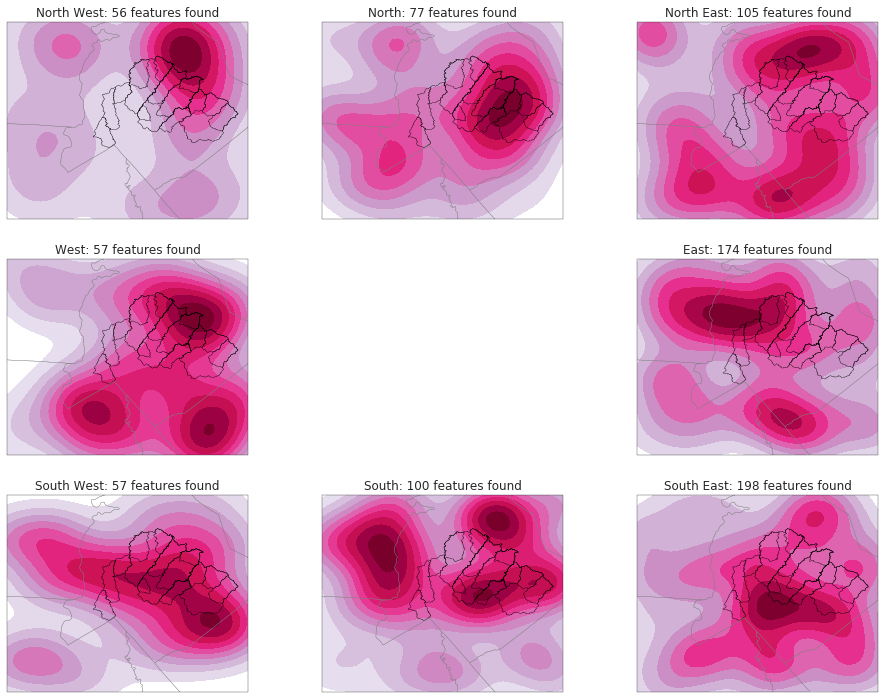

In [707]:
pos=True
neg=False
plt.figure(figsize=(16,12))
for i, b in enumerate(dirs8):
    if i ==4:
        continue
    ax = plt.subplot(3, 3, b[4], projection=ccrs.PlateCarree())
    ax.add_geometries(basins, ccrs.PlateCarree(), edgecolor='black', facecolor='None')
    ax.add_geometries(county, ccrs.PlateCarree(), edgecolor='gray', facecolor='None')
    ax.set_extent(buffer_extent, ccrs.PlateCarree())
    lon, lat = get_lon_lat(b, pos, neg)
    if pos:
        cmap="PuRd"
    elif neg:
        cmap="PuBu"
    else:
        cmap="BuGn"
    ax = sns.kdeplot(lon, lat, cmap=cmap, ax=ax, shade=True, shade_lowest=False)
    ax.set_title('{direction}: {k} features found'.format(direction=b[2], k=len(lon)))
plt.savefig('/home/jsignell/Paper/Notebooks/output/Binary KDE increase (8 dir).png')

In [365]:
%matplotlib inline
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import pandas as pd 
import numpy as np

large_extent = [-82, -80, 34.5, 36]
small_extent = [-81.035000-.01, -80.552222+.01, 35.019722-.01, 35.507778+.01]

fname = '../../data/CHARLOTTE/Maps/new_basin.shp'
basins = list(shpreader.Reader(fname).geometries())

fname = '../../data/CHARLOTTE/Maps/county.shp'
county = list(shpreader.Reader(fname).geometries())

cmap = plt.cm.get_cmap('jet', 10)
cmap.set_under(color='None')


def radar_map(radar, feat=False, save=False, storm_mean=False, t_end=None, nrows=1, ncols=1, n=1, **kwargs):
    ax = plt.subplot(nrows, ncols, n, projection=ccrs.PlateCarree())

    ax.set_title(radar.t)
    i = radar.time.get_loc(radar.t)
    ax.add_geometries(basins, ccrs.PlateCarree(), edgecolor='black', facecolor='None')
    ax.add_geometries(county, ccrs.PlateCarree(), edgecolor='gray', facecolor='None')
    #ax.set_extent(small_extent, ccrs.PlateCarree())
    
    if storm_mean:
        scat = ax.pcolor(radar.lon, radar.lat, radar.box.mean(0),cmap=cmap, alpha=.7)
        plt.colorbar(scat, fraction=0.05)
    else:
        scat = ax.pcolor(radar.lon, radar.lat, radar.box[i,:,:], vmin=.1, vmax=100, cmap=cmap)
    if feat:
        try:
            #ax.scatter(p[radar.t].lon, p[radar.t].lat, c='black',s=200)
            ax.scatter(p[radar.t].centroidX, p[radar.t].centroidY, c='black',s=100)
        except:
            print 'no features found'
            pass
    if 'at' in kwargs:
        if 'colors' in kwargs:
            color=kwargs['colors']
        else:
            color='black'
        ax.scatter(x=kwargs['at'][0], y=kwargs['at'][1], c=color,s=100)
    return(scat, ax)

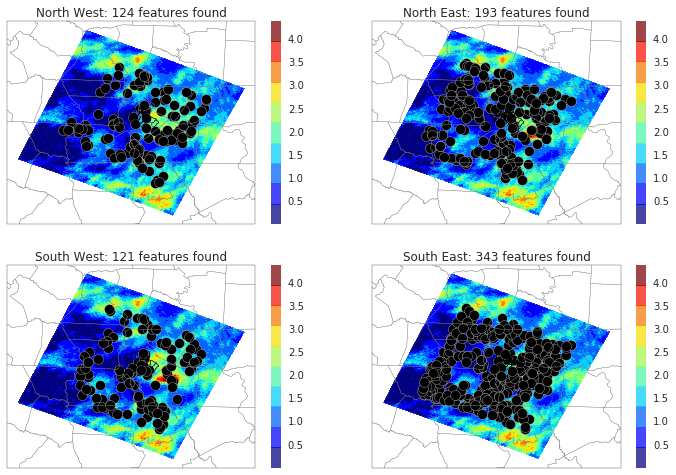

In [557]:
n=1
plt.figure(figsize=(12,8))
for b in dirs4:
    bool_array = (p[:,:,'Bearing']>b[0]) & (p[:,:,'Bearing']<b[1])
    lon=p[:,:,'centroidX'][bool_array].stack().values
    lat=p[:,:,'centroidY'][bool_array].stack().values
    scat, ax = radar_map(c, storm_mean=True, at=[lon, lat], nrows=2, ncols=2, n=n, colors=['black'])
    ax.set_title('{direction}: {k} features found'.format(direction=b[2], k=len(lon)))
    n+=1